In [1]:
import numpy as np
import pandas as pd
import geopandas as gp
import matplotlib.pyplot as plt
import glob
import os

pd.set_option('display.max_rows', None)
pd.set_option('display.max_columns', None)

# VEST NJ 2018

## VEST's Documentation File

Election results primarily from individual county canvass reports via OpenElections (https://github.com/openelections/openelections-data-nj/). Results from Camden, Cape May, Essex, Hunterdon, Middlesex, and Salem counties were partly or wholly replaced using the Statement of the Vote from the respective counties.  
  
Precinct shapefile from New Jersey Geographic Information Network (https://njogis-newjersey.opendata.arcgis.com/datasets/election-districts-for-new-jersey). Naval Weapons Station Earle in Monmouth County was added as an unassigned district.  
  
All counties except Sussex and Warren report mail votes and provisional votes at the municipal and/or ward level. Essex, Gloucester, Hudson, Monmouth, Ocean, and Union further subdivide these vote types by other districts on the same ballot. Camden, Cape May, Essex, Gloucester, Hudson, Monmouth, Morris, Salem, and Sussex reported overseas ballots countywide or by congressional district. All votes were distributed by candidate to precincts based on their share of the precinct-level reported vote of the respective reporting unit.  
  
The following modifications to the shapefile were made to reverse changes in precinct boundaries enacted since 2018.  
  
Hudson: Merge Jersey City Ward E 9/24, 6/25  
  
G18USSDMEN - Robert Menendez (Democratic Party)  
G18USSRHUG - Bob Hugin (Republican Party)  
G18USSLSAB - Murray Sabrin (Libertarian Party)  
G18USSGHOF - Madelyn R. Hoffman (Green Party)  
G18USSORIV - Natalie Lynn Rivera (For The People)  
G18USSOFLA - Tricia Flanagan (New Day NJ)  
G18USSOKIM - Kevin Kimple (Make It Simple)  
G18USSOSCH - Hank Schroeder (Economic Growth)  

In [2]:
vest_shp = gp.read_file("./raw-from-source/VEST/nj_2018/nj_2018.shp")

In [3]:
vest_shp.shape

(6347, 19)

In [4]:
vest_shp.head(1)

,CONGR_DIST,LEGIS_DIST,COCOM_DIST,ELECD_KEY,COUNTY,MUN_NAME,MCODE_SVRS,MCODE_1040,WARD_CODE,ELECD_CODE,G18USSDMEN,G18USSRHUG,G18USSLSAB,G18USSGHOF,G18USSORIV,G18USSOFLA,G18USSOKIM,G18USSOSCH,geometry
0,02,02,05,001-0117-01-00,Atlantic,Mullica Township,0117,0117,01,00,312,281,6,2,13,1,0,4,"POLYGON ((427942.516 266334.807, 426253.899 26..."


Import election results

In [5]:
election_results = pd.read_csv("./raw-from-source/CountyData/20181106__nj__general__municipal.csv")

In [6]:
election_results = election_results[election_results['office']=='U.S. Senate']

In [7]:
election_results.head(1)

,county,municipality,office,district,party,candidate,votes
3260,Atlantic,Absecon City,U.S. Senate,NaN,Democratic,Robert Menendez,1551


In [8]:
election_results.candidate.unique()

array(['Robert Menendez', 'Bob Hugin', 'Tricia Flanagan',
       'Madelyn R. Hoffman', 'Kevin Kimple', 'Natalie Lynn Rivera',
       'Murray Sabrin', 'Hank Schroeder'], dtype=object)

In [9]:
#Load in the nationwide FIPS file
fips_file = pd.read_csv("./raw-from-source/FIPS/US_FIPS_Codes.csv")
fips_file = fips_file[fips_file["State"]=="New Jersey"]
fips_file["FIPS County"]=fips_file["FIPS County"].astype(str)

#Make the FIPS three digits
fips_file["FIPS County"]=fips_file["FIPS County"].str.zfill(3)

#Make FIPS County Name uppercase
fips_file['County Name']=fips_file['County Name'].str.upper()

#Create the dictionary
nj_fips_dict = dict(zip(fips_file["County Name"],fips_file["FIPS County"]))
#Create list of fips codes
fips_file["unique_ID"] =  "34" + fips_file["FIPS County"]
fips_codes = fips_file["unique_ID"].tolist()
nj_fips_dict

{'ATLANTIC': '001',
 'BERGEN': '003',
 'BURLINGTON': '005',
 'CAMDEN': '007',
 'CAPE MAY': '009',
 'CUMBERLAND': '011',
 'ESSEX': '013',
 'GLOUCESTER': '015',
 'HUDSON': '017',
 'HUNTERDON': '019',
 'MERCER': '021',
 'MIDDLESEX': '023',
 'MONMOUTH': '025',
 'MORRIS': '027',
 'OCEAN': '029',
 'PASSAIC': '031',
 'SALEM': '033',
 'SOMERSET': '035',
 'SUSSEX': '037',
 'UNION': '039',
 'WARREN': '041'}

In [10]:
candidates_dict = {'Robert Menendez':'G18USSDMEN', 
                   'Bob Hugin':'G18USSRHUG', 
                   'Tricia Flanagan':'G18USSOFLA',
                   'Madelyn R. Hoffman':'G18USSGHOF',
                   'Kevin Kimple':'G18USSOKIM', 
                   'Natalie Lynn Rivera':'G18USSORIV',
                   'Murray Sabrin':'G18USSLSAB',
                   'Hank Schroeder':'G18USSOSCH'
                  }

In [11]:
election_results["candidate"] = election_results["candidate"].map(candidates_dict).fillna(election_results["candidate"])

In [12]:
office_list = ['G18USSDMEN', 'G18USSRHUG', 'G18USSOFLA','G18USSGHOF','G18USSOKIM', 'G18USSORIV','G18USSLSAB','G18USSOSCH']

In [13]:
election_results = election_results[election_results["candidate"].isin(office_list)]

In [14]:
#Uppercase Counties
election_results['county']=election_results['county'].str.upper()
vest_shp['COUNTY']=vest_shp['COUNTY'].str.upper()

#Add FIPS columns
election_results["COUNTYFP"] = election_results["county"].map(nj_fips_dict).fillna(election_results["county"])
vest_shp["COUNTYFP"] = vest_shp['COUNTY'].map(nj_fips_dict).fillna(vest_shp['COUNTY'])

In [15]:
election_results.head(1)

,county,municipality,office,district,party,candidate,votes,COUNTYFP
3260,ATLANTIC,Absecon City,U.S. Senate,NaN,Democratic,G18USSDMEN,1551,001


In [16]:
#Clean up precinct column by stripping the white space
election_results["municipality"]=election_results["municipality"].str.strip()

#Create a column to pivot table by concatenation the FIPS and precinct columns
election_results["pivot_col"]=election_results["COUNTYFP"]+election_results["municipality"]

In [17]:
#Run the pivot
pivoted_election_results = pd.pivot_table(election_results,values=["votes"],index=["pivot_col"],columns=["candidate"],aggfunc=sum)

#Fill in N/A with 0
pivoted_election_results = pivoted_election_results.fillna(0)

#Clean the columns
pivoted_election_results.reset_index(drop=False,inplace=True)
pivoted_election_results.columns = pivoted_election_results.columns.droplevel(0)

In [18]:
pivoted_election_results.head(1)

candidate,,G18USSDMEN,G18USSGHOF,G18USSLSAB,G18USSOFLA,G18USSOKIM,G18USSORIV,G18USSOSCH,G18USSRHUG
0,001Absecon City,1551,33,26,8,4,61,22,1961


In [19]:
pivoted_election_results.rename(columns={ pivoted_election_results.columns[0]: "join_col" }, inplace = True)
pivoted_election_results.columns = pivoted_election_results.columns.get_level_values(0)

In [20]:
#Add FIPS State and County columns
pivoted_election_results.insert(loc=0, column='STATEFP', value='34')
pivoted_election_results.insert(loc=1, column='COUNTYFP', value=pivoted_election_results['join_col'].str[0:3])
pivoted_election_results.insert(loc=3, column='Precinct', value=pivoted_election_results['join_col'].str[3:])

In [21]:
election_results=pivoted_election_results
#Delete total votes
election_results=election_results[election_results['Precinct']!='Total']
election_results.head(1)

candidate,STATEFP,COUNTYFP,join_col,Precinct,G18USSDMEN,G18USSGHOF,G18USSLSAB,G18USSOFLA,G18USSOKIM,G18USSORIV,G18USSOSCH,G18USSRHUG
0,34,001,001Absecon City,Absecon City,1551,33,26,8,4,61,22,1961


In [22]:
election_results['COUNTYFP'] = election_results['COUNTYFP'].str.zfill(3)

<ipython-input-22-e177524d3b55>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  election_results['COUNTYFP'] = election_results['COUNTYFP'].str.zfill(3)


## Compare Election Results

In [23]:
races = [x for x in vest_shp.columns if 'G18' in x]
races

['G18USSDMEN',
 'G18USSRHUG',
 'G18USSLSAB',
 'G18USSGHOF',
 'G18USSORIV',
 'G18USSOFLA',
 'G18USSOKIM',
 'G18USSOSCH']

In [24]:
sum_var_1 = 0
sum_var_2 = 0
for i in races:
    sum_var_1 += np.sum(vest_shp[i])
    sum_var_2 += np.sum(election_results[i])
print(sum_var_1)
print(sum_var_2)

3169310
3169310


### Compare Race Totals

In [25]:
def statewide_totals_check(partner_df,source_df,column_list):
    print("***Statewide Totals Check***")
    for race in column_list:
        if (sum(partner_df[race])- source_df[race].sum() != 0):
            print(race+" has a difference of "+str(sum(partner_df[race])-source_df[race].sum())+" votes")
            print("\tVEST: "+str(sum(partner_df[race]))+" votes")
            print("\tSOURCES: "+str(source_df[race].sum())+" votes")
        else:
            print(race + " is equal", "\tVEST / RDH: " + str(sum(partner_df[race])))

In [26]:
statewide_totals_check(vest_shp,election_results,races)

***Statewide Totals Check***
G18USSDMEN is equal 	VEST / RDH: 1711654
G18USSRHUG is equal 	VEST / RDH: 1357355
G18USSLSAB is equal 	VEST / RDH: 21212
G18USSGHOF is equal 	VEST / RDH: 25150
G18USSORIV is equal 	VEST / RDH: 19897
G18USSOFLA is equal 	VEST / RDH: 16101
G18USSOKIM is equal 	VEST / RDH: 9087
G18USSOSCH is equal 	VEST / RDH: 8854


### Compare County Totals

In [27]:
def county_totals_check(partner_df,source_df,column_list,county_col,full_print=False):
    print("***Countywide Totals Check***")
    print("")
    diff_counties=[]
    for race in column_list:
        diff = partner_df.groupby([county_col]).sum()[race]-source_df.groupby([county_col]).sum()[race]
        for val in diff[diff != 0].index.values.tolist():
            if val not in diff_counties:
                diff_counties.append(val)
        if len(diff[diff != 0]!=0):   
            print(race + " contains differences in these counties:")
            for val in diff[diff != 0].index.values.tolist():
                county_differences = diff[diff != 0]
                print("\t"+val+" has a difference of "+str(county_differences[val])+" votes")
                print("\t\tVEST: "+str(partner_df.groupby([county_col]).sum().loc[val,race])+" votes")
                print("\t\tSOURCES: "+str(source_df.groupby([county_col]).sum().loc[val,race])+" votes")
            if (full_print):
                for val in diff[diff == 0].index.values.tolist():
                    county_similarities = diff[diff == 0]
                    print("\t"+val + ": "+ str(partner_df.groupby([county_col]).sum().loc[val,race])+" votes")
        else:
            print(race + " is equal across all counties")
            if (full_print):
                for val in diff[diff == 0].index.values.tolist():
                    county_similarities = diff[diff == 0]
                    print("\t"+val + ": "+ str(partner_df.groupby([county_col]).sum().loc[val,race])+" votes")

In [28]:
county_totals_check(vest_shp,election_results,races,'COUNTYFP')

***Countywide Totals Check***

G18USSDMEN is equal across all counties
G18USSRHUG is equal across all counties
G18USSLSAB is equal across all counties
G18USSGHOF is equal across all counties
G18USSORIV is equal across all counties
G18USSOFLA is equal across all counties
G18USSOKIM is equal across all counties
G18USSOSCH is equal across all counties


# Precinct Shapefiles
## Documentation
Precinct shapefile from New Jersey Geographic Information Network (https://njogis-newjersey.opendata.arcgis.com/datasets/election-districts-for-new-jersey). 
Naval Weapons Station Earle in Monmouth County was added as an unassigned district.

In [29]:
shapefiles_nj = gp.read_file('./raw-from-source/NJGIN/Election_Districts_for_New_Jersey-shp/Election_Districts_for_New_Jersey.shp')

In [30]:
vest_shp = vest_shp.to_crs(3857)
shapefiles_nj = shapefiles_nj.to_crs(3857)

In [31]:
shapefiles_nj.head(10)

,OBJECTID,CONGR_DIST,LEGIS_DIST,COCOM_DIST,ELECD_KEY,COUNTY,MUN_NAME,MCODE_SVRS,MCODE_1040,WARD_CODE,ELECD_CODE,Shape__Are,Shape__Len,geometry
0,1,02,02,05,001-0117-01-<NULL>,Atlantic,Mullica Township,0117,0117,01,None,2.558230e+08,93039.816361,"POLYGON ((-8318646.528 4802842.737, -8319314.8..."
1,2,02,02,05,001-0105-00-02,Atlantic,Buena Vista Township,0105,0105,00,02,2.138871e+08,72112.443970,"POLYGON ((-8338841.803 4787971.658, -8339593.6..."
2,3,02,02,05,001-0105-00-01,Atlantic,Buena Vista Township,0105,0105,00,01,4.159304e+08,118020.966221,"POLYGON ((-8333012.058 4782129.582, -8333006.6..."
3,4,02,02,05,001-0105-00-03,Atlantic,Buena Vista Township,0105,0105,00,03,4.590737e+08,103180.242196,"POLYGON ((-8336396.193 4804277.755, -8335661.4..."
4,5,02,02,02,001-0116-00-03,Atlantic,Margate City,0116,0116,00,03,1.367352e+07,17848.592607,"POLYGON ((-8294709.534 4770138.628, -8293691.6..."
5,6,02,02,02,001-0116-00-01,Atlantic,Margate City,0116,0116,00,01,1.307732e+07,20353.014715,"POLYGON ((-8292775.182 4769933.741, -8292741.5..."
6,7,02,02,02,001-0116-00-04,Atlantic,Margate City,0116,0116,00,04,7.900803e+06,12128.074494,"POLYGON ((-8294300.321 4767682.018, -8294312.0..."
7,8,02,02,02,001-0116-00-02,Atlantic,Margate City,0116,0116,00,02,1.084788e+07,16749.702170,"POLYGON ((-8293654.283 4769594.836, -8293550.9..."
8,9,02,02,02,001-0115-00-01,Atlantic,Longport Borough,0115,0115,00,01,1.656157e+07,24406.766035,"POLYGON ((-8295073.911 4767203.818, -8295065.5..."
9,10,02,02,02,001-0121-02-04,Atlantic,Somers Point City,0121,0121,02,04,1.672089e+07,22090.743662,"POLYGON ((-8304438.064 4770121.124, -8304424.7..."


In [32]:
shapefiles_nj['ELECD_KEY'] = shapefiles_nj['ELECD_KEY'].replace({'<NULL>': '00'}, regex=True)

<AxesSubplot:>

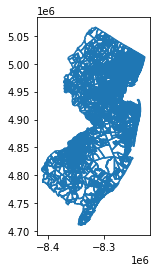

In [33]:
shapefiles_nj.boundary.plot()

In [34]:
print(shapefiles_nj.shape)
vest_shp.shape

(6348, 14)


(6347, 20)

<AxesSubplot:>

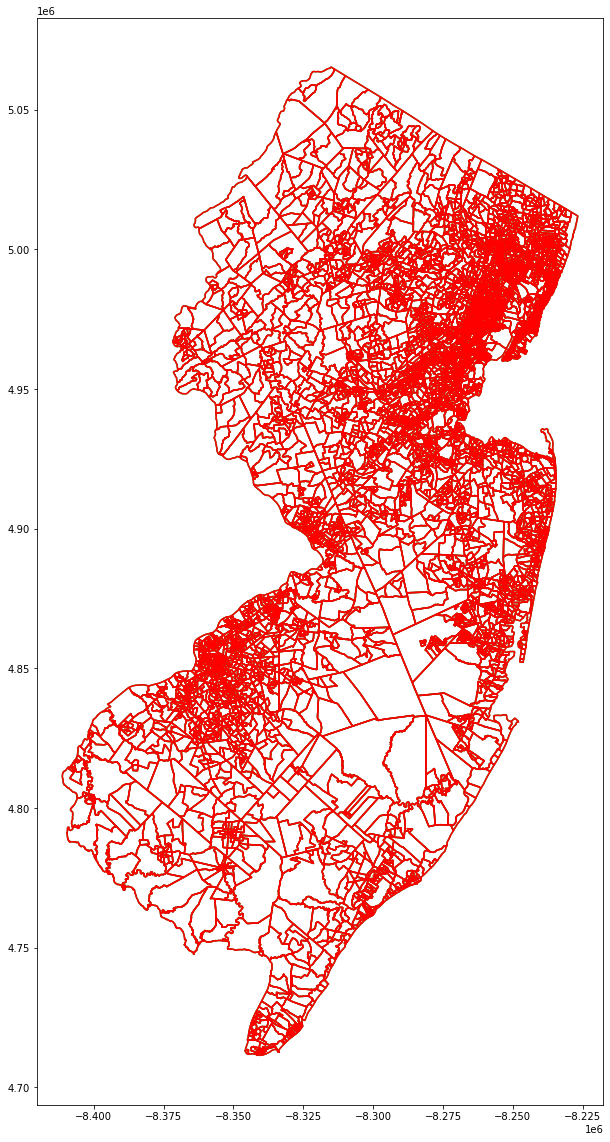

In [35]:
ax = shapefiles_nj.boundary.plot(figsize=(20,20),color="green")
vest_shp.boundary.plot(figsize=(20,20),ax=ax,color="red")

## Complete Merges

VEST- Hudson: Merge Jersey City Ward E 9/24, 6/25; Realign Union City Ward 9 precincts  
Passaic: Merge Pompton Lakes 3/6  

<AxesSubplot:>

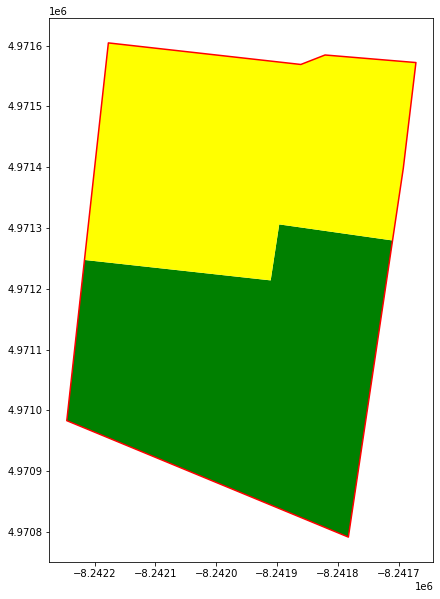

In [36]:
ax = vest_shp[vest_shp['ELECD_KEY'] == '017-0906-E-09'].boundary.plot(figsize=(10,10),color="red")
shapefiles_nj[shapefiles_nj['ELECD_KEY'] == '017-0906-E-09'].plot(figsize=(10,10),ax=ax,color="green")
shapefiles_nj[shapefiles_nj['ELECD_KEY'] == '017-0906-E-24'].plot(figsize=(10,10),ax=ax,color="yellow")

In [37]:
#Merge precincts in Hudson
prec2combine = [shapefiles_nj.loc[shapefiles_nj["ELECD_KEY"]=="017-0906-E-09"],shapefiles_nj.loc[shapefiles_nj["ELECD_KEY"]=="017-0906-E-24"]]
new_fort = gp.GeoDataFrame(pd.concat(prec2combine, ignore_index=True), crs = 32100)
shapefiles_nj.loc[shapefiles_nj["ELECD_KEY"]=="017-0906-E-09","geometry"]=new_fort.unary_union
shapefiles_nj = shapefiles_nj[shapefiles_nj["ELECD_KEY"]!="017-0906-E-24"]

<ipython-input-37-d40cc0d15d90>:3: FutureWarning: CRS mismatch between CRS of the passed geometries and 'crs'. Use 'GeoDataFrame.set_crs(crs, allow_override=True)' to overwrite CRS or 'GeoDataFrame.to_crs(crs)' to reproject geometries. CRS mismatch will raise an error in the future versions of GeoPandas.
  new_fort = gp.GeoDataFrame(pd.concat(prec2combine, ignore_index=True), crs = 32100)


<AxesSubplot:>

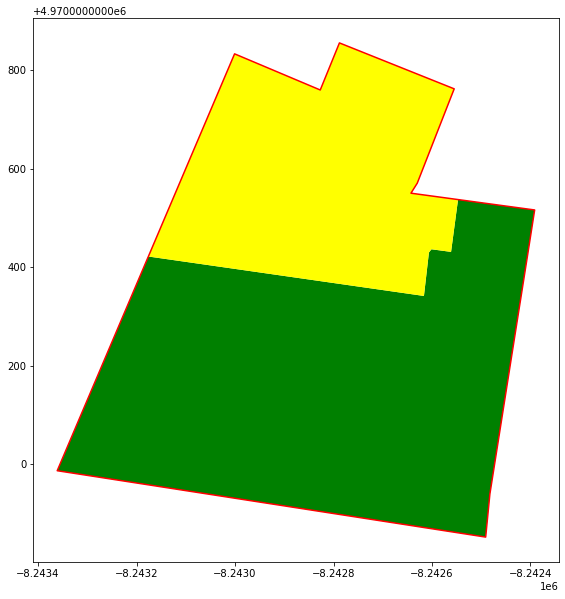

In [38]:
ax = vest_shp[vest_shp['ELECD_KEY'] == '017-0906-E-06'].boundary.plot(figsize=(10,10),color="red")
shapefiles_nj[shapefiles_nj['ELECD_KEY'] == '017-0906-E-06'].plot(figsize=(10,10),ax=ax,color="green")
shapefiles_nj[shapefiles_nj['ELECD_KEY'] == '017-0906-E-25'].plot(figsize=(10,10),ax=ax,color="yellow")

In [39]:
#Merge precincts in Hudson
prec2combine = [shapefiles_nj.loc[shapefiles_nj["ELECD_KEY"]=="017-0906-E-06"],shapefiles_nj.loc[shapefiles_nj["ELECD_KEY"]=="017-0906-E-25"]]
new_fort = gp.GeoDataFrame(pd.concat(prec2combine, ignore_index=True), crs = 32100)
shapefiles_nj.loc[shapefiles_nj["ELECD_KEY"]=="017-0906-E-06","geometry"]=new_fort.unary_union
shapefiles_nj = shapefiles_nj[shapefiles_nj["ELECD_KEY"]!="017-0906-E-25"]

<ipython-input-39-7886eb6963d0>:3: FutureWarning: CRS mismatch between CRS of the passed geometries and 'crs'. Use 'GeoDataFrame.set_crs(crs, allow_override=True)' to overwrite CRS or 'GeoDataFrame.to_crs(crs)' to reproject geometries. CRS mismatch will raise an error in the future versions of GeoPandas.
  new_fort = gp.GeoDataFrame(pd.concat(prec2combine, ignore_index=True), crs = 32100)


In [40]:
final_merge = pd.merge(shapefiles_nj,vest_shp,how="outer",on="ELECD_KEY",indicator="final_merge")
final_merge["final_merge"].value_counts()

both          6346
right_only       1
left_only        0
Name: final_merge, dtype: int64

In [41]:
final_merge[final_merge["final_merge"] != 'both'][['COUNTY_x','MUN_NAME_x','COUNTY_y','MUN_NAME_y','ELECD_KEY']]

,COUNTY_x,MUN_NAME_x,COUNTY_y,MUN_NAME_y,ELECD_KEY
6346,NaN,NaN,MONMOUTH,Middletown Township,025-1331-00-00


In [42]:
both = final_merge[final_merge["final_merge"]=="both"]
vest_geoms = gp.GeoDataFrame(both,geometry="geometry_x")
source_geoms = gp.GeoDataFrame(both,geometry="geometry_y")
source_geoms = source_geoms.to_crs(3857)
vest_geoms = vest_geoms.to_crs(3857)
source_geoms["geometry_x"]=source_geoms.buffer(0)
vest_geoms["geometry_y"]=vest_geoms.buffer(0)
vals = source_geoms.geom_almost_equals(vest_geoms,decimal=0)
print(vals.value_counts())

True     6343
False       3
dtype: int64


In [43]:
count = 0
area_list = []
for i in range(0,len(source_geoms)):
    diff = source_geoms.iloc[[i]].symmetric_difference(vest_geoms.iloc[[i]])
    intersection = source_geoms.iloc[[i]].intersection(vest_geoms.iloc[[i]])
    area = float(diff.area/10e6)
    area_list.append(area)
    #print("Area is " + str(area))

    if (area > .5):
        count += 1
        name = source_geoms.iat[i,3]
        county = source_geoms.iat[i,1]
        
        print(str(count)+") For " + str(county) + '-' + str(name) + " difference in area is " + str(area))
        if (intersection.iloc[0].is_empty):
            base = diff.plot(color="red")
            source_geoms.iloc[[i]].plot(color="orange",ax=base)
            vest_geoms.iloc[[i]].plot(color="blue",ax=base)
            base.set_title(name)
        else:
            base = diff.plot(color="red")
            source_geoms.iloc[[i]].plot(color="orange",ax=base)
            vest_geoms.iloc[[i]].plot(color="blue",ax=base)
            intersection.plot(color="green",ax=base)
            base.set_title(name)

In [44]:
df = pd.DataFrame(area_list)
print(df.shape)

print(str(len(df[df[0]==0]))+" precincts w/ a difference of 0 km^2")
print(str(len(df[(df[0]<.1) & (df[0]>0)]))+ " precincts w/ a difference between 0 and 0.1 km^2")
print(str(len(df[(df[0]<.5) & (df[0]>=.1)]))+ " precincts w/ a difference between 0.1 and 0.5 km^2")
print(str(len(df[(df[0]<1) & (df[0]>=.5)]))+ " precincts w/ a difference between 0.5 and 1 km^2")
print(str(len(df[(df[0]<2) & (df[0]>=1)]))+ " precincts w/ a difference between 1 and 2 km^2")
print(str(len(df[(df[0]<5) & (df[0]>=2)]))+ " precincts w/ a difference between 2 and 5 km^2")
print(str(len(df[(df[0]>=5)]))+ " precincts w/ a difference greater than 5 km^2")

(6346, 1)
6345 precincts w/ a difference of 0 km^2
1 precincts w/ a difference between 0 and 0.1 km^2
0 precincts w/ a difference between 0.1 and 0.5 km^2
0 precincts w/ a difference between 0.5 and 1 km^2
0 precincts w/ a difference between 1 and 2 km^2
0 precincts w/ a difference between 2 and 5 km^2
0 precincts w/ a difference greater than 5 km^2
